In [1]:
import pandas as pd
import numpy as np
from vivarium import Artifact
import os
from pathlib import Path
from db_queries import get_outputs, get_ids, get_model_results, get_population
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gbd_mapping
from matplotlib.backends.backend_pdf import PdfPages
pd.set_option('use_inf_as_na', True)
sns.set(context = 'paper', style='whitegrid', font_scale=1.8, rc = {'axes.spines.right':False, 'axes.spines.top': False, 'figure.figsize':(12.7,8.6)}, palette='Set1')


## Change variable save_path to local directory file path for file results

In [2]:
mapping_dict_data = {'cause': {'acute_myocardial_infarction':'ischemic_heart_disease','post_myocardial_infarction':'ischemic_heart_disease','acute_ischemic_stroke':'ischemic_stroke','post_ischemic_stroke':'ischemic_stroke', 'ischemic_stroke':'ischemic_stroke', 'chronic_kidney_disease':'chronic_kidney_disease', 'ischemic_heart_disease':'ischemic_heart_disease', 'diabetes_mellitus':'diabetes_mellitus', 'other_causes':'other_causes', 'albuminuria':'chronic_kidney_disease', 'stage_iii_chronic_kidney_disease':'chronic_kidney_disease','stage_iv_chronic_kidney_disease':'chronic_kidney_disease','stage_v_chronic_kidney_disease':'chronic_kidney_disease','moderate_diabetes_mellitus':'diabetes_mellitus','severe_diabetes_mellitus':'diabetes_mellitus', 'chronic_kidney_disease':'chronic_kidney_disease'},
                    'sequela':{378:'acute_myocardial_infarction', 379:'acute_myocardial_infarction',380:'post_myocardial_infarction', 381:'post_myocardial_infarction', 382:'post_myocardial_infarction', 383:'post_myocardial_infarction', 384:'post_myocardial_infarction', 385:'post_myocardial_infarction', 953:'post_myocardial_infarction', 1040:'post_myocardial_infarction', 5726:'post_myocardial_infarction', 386: 'acute_ischemic_stroke', 387: 'acute_ischemic_stroke', 388: 'acute_ischemic_stroke', 389: 'acute_ischemic_stroke', 390: 'acute_ischemic_stroke', 391:'post_ischemic_stroke', 392: 'post_ischemic_stroke', 393:'post_ischemic_stroke', 394:'post_ischemic_stroke', 395:'post_ischemic_stroke', 946:'post_ischemic_stroke'},
                    'location': {'china':'China', 'brazil':'Brazil', 'france':'France', 'italy':'Italy', 'russian_federation':'Russian Federation', 'spain':'Spain'},
                    'sex':{'female':'Female','male':'Male'},
                    'measure':{'death':'deaths','ylds':'ylds','ylls':'ylls'},
                    'model_6_results':{'brazil':'brazil/2020_04_04_02_39_35','china':'china/2020_04_04_02_40_14'}}


locations = ['brazil','china']
measures = ['deaths', 'person_time','population','ylds','ylls', 'prevalence', 'incidence']
save_path_j = '/home/j/Project/simulation_science/zenon/validation/model_6'

In [3]:
def get_gbd_outputs(location):
    locations = {'brazil': 135,
                 'china': 6,
                 'italy': 86,
                 'france': 80,
                 'spain': 92,
                 'russian_federation': 62}
    loc_id = locations[location]
    from gbd_mapping import causes
    ages = list(range(11, 21)) + [30, 31, 32, 235]
    male, female = 1, 2
    rate = 3
    deaths, ylds, ylls, prevalence, incidence = 1, 3, 4, 5, 6
    cause_names = ['ischemic_heart_disease', 'ischemic_stroke', 'chronic_kidney_disease', 'diabetes_mellitus']
    cause_map = {c.gbd_id: c.name for c in causes if c.name in cause_names}

    gbd_outputs = get_outputs('cause', cause_id=list(cause_map.keys()), 
                              metric_id=[rate], measure_id=[deaths,ylls, ylds,prevalence, incidence], 
                              sex_id = [male, female], age_group_id=ages,
                              location_id=loc_id, gbd_round_id=5, year_id=2017)
    
    gbd_outputs = gbd_outputs[['cause_id', 'year_id','age_group_name', 'measure_name', 'sex', 'val', 'upper', 'lower']]
    gbd_outputs['cause'] = gbd_outputs.cause_id.map(cause_map)
    gbd_outputs['location'] = f'{location}'
    gbd_outputs['measure'] = gbd_outputs.measure_name.map({'Deaths':'deaths',
                                                           'YLLs (Years of Life Lost)': 'ylls',
                                                           'YLDs (Years Lived with Disability)': 'ylds',
                                                           'Prevalence': 'prevalence',
                                                           'Incidence': 'incidence'})
    gbd_outputs['age_group'] = gbd_outputs.age_group_name.str.replace(' ', '_')
    gbd_outputs = gbd_outputs.rename(columns={'year_id':'year'})
    gbd_outputs = gbd_outputs.drop(columns=['cause_id', 'measure_name', 'age_group_name'])
    gbd = gbd_outputs.set_index(['cause', 'measure', 'sex', 'age_group']).sort_index().reset_index()
    gbd[['val', 'upper', 'lower']] *= 100_000

    return gbd
    

In [4]:
def get_gbd_outputs_all(locations):
    gbd_outputs = pd.DataFrame()
    for location in locations:
        data = get_gbd_outputs(location)
        gbd_outputs = gbd_outputs.append(data)
    return gbd_outputs

## Zenon Model 6 results







In [5]:
path_template = Path('/ihme/costeffectiveness/results/vivarium_csu_zenon/v6.0_baseline_treatment')

def get_model_outputs_sequela(locations, measure):
    outcomes = pd.DataFrame([])
    try:   
        for location in locations:
            country_loc = mapping_dict_data['model_6_results'][location]
            outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/{measure}.hdf'))
            outcome['location'] = f'{location}'
            if measure != 'transition_count':
                outcome['measure'] = f'{measure}'
            outcomes = outcomes.append(outcome)
        return outcomes
            
    except:
        print(f'{measure} is not a measure in the outputs')

def get_model_outputs_cause(locations, measure):
    outcomes = pd.DataFrame([])
    try:   
    
        for location in locations:
            country_loc = mapping_dict_data['model_6_results'][location]
            outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/{measure}.hdf'))
            outcome['location'] = f'{location}'
        
            if measure != 'transition_count':
                outcome['measure'] = f'{measure}'
            outcomes = outcomes.append(outcome)
        outcomes['cause'] = outcomes.cause.map(mapping_dict_data['cause'])
        outcomes = outcomes.groupby(['age_group','sex','year','cause','input_draw','location']).value.sum().reset_index()

        return outcomes
            
    except:
            print(f'{measure} is not a measure in the outputs')

    

In [6]:
def get_pops(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_6_results'][country]
        outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/population.hdf'))
        outcome['location'] = f'{country}'
        outcomes = outcomes.append(outcome)
    return outcomes

def get_person_time(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_6_results'][country]
        outcome = pd.read_hdf(str(path_template / f'{country_loc}/count_data/person_time.hdf'))
        outcome['location'] = f'{country}'
        outcomes = outcomes.append(outcome)
    outcomes = outcomes.groupby(['age_group','sex','year','input_draw', 'location']).value.sum().reset_index()
    return outcomes

deaths = get_model_outputs_sequela(locations, 'deaths')
state = get_model_outputs_sequela(locations, 'state_person_time')

def get_emr(locations, deaths, state):
    
    index_columns = ['age_group', 'sex', 'year', 'input_draw','location', 'cause']
    deaths['measure'] = 'deaths'
    deaths = deaths[((deaths.cause == 'acute_myocardial_infarction') | (deaths.cause == 'post_myocardial_infarction') | (deaths.cause == 'acute_ischemic_stroke') | (deaths.cause == 'post_ishemic_stroke'))& (deaths.year == '2020')]
    state['measure'] = 'state'
    state = state[((state.cause == 'acute_myocardial_infarction') | (state.cause == 'post_myocardial_infarction') |  (state.cause == 'acute_ischemic_stroke') | (state.cause == 'post_ischemic_stroke')) & (state.year == '2020')]
    deaths  = deaths.set_index(index_columns).value
    state = state.set_index(index_columns).value
    rates = deaths / state * 100_000
    rates = rates.reset_index()
    rates['value'] = rates['value'].fillna(0)
    rates['measure'] = 'excess_mortality_rate'
    rates['sex'] = rates.sex.map(mapping_dict_data['sex'])
    return rates

def get_transition(locations):
    outcomes = pd.DataFrame([])
    for country in locations:
        country_loc = mapping_dict_data['model_6_results'][country]
        df = pd.read_hdf(str(path_template / f'{country_loc}/count_data/transition_count.hdf'))
        df['location'] = f'{country}'
        outcomes = outcomes.append(df)
    return outcomes

def get_transition_susceptible_to_acute(locations):
    transitions = get_model_outputs_sequela(locations, 'transition_count')
    transitions = transitions[transitions.measure.str.startswith('susceptible')]
    transitions['susceptible'] = transitions.measure.str.extract('((?<=to_).*?(?=_to))',expand = False)
    transitions['cause'] = transitions.measure.str.extract('((?<=to_).*?(?=_event_count))',expand = False)
    transitions['cause'] = transitions.cause.str.extract('((?<=_to_).*)', expand = False)
    transitions = transitions.drop('measure', axis = 1)
    return transitions

# def get_transition_post_to_acute(locations):    
#     transitions = get_model_outputs_sequela(locations, 'transition_count')
#     transitions = transitions[transitions.measure.str.startswith('post')]
#     transitions['susceptible'] = transitions.measure.str.extract('(.*?(?=_to))',expand = False)
#     transitions['cause'] = transitions.measure.str.extract('((?<=to_).*?(?=_event_count))',expand = False)
#     transitions = transitions.drop('measure', axis = 1)
#     return transitions

susceptible_to_acute = get_transition_susceptible_to_acute(locations)
# post_to_acute = get_transition_post_to_acute(locations)


def collapse_frame(df, column):
    return(df.groupby([x for x in df.columns if x not in ['value',column]])['value'].sum().reset_index())

def get_incidence(susceptible_to_acute, post_to_acute, locations, risk_strat = False, final_cause_strat = False):
    transitions = pd.concat([susceptible_to_acute, post_to_acute])
    state = get_model_outputs_sequela(locations, 'state_person_time')
    state = state.groupby(['age_group','sex','year','cause','input_draw','location', 'measure']).value.sum().reset_index()
    state = state[(state.cause.str.contains('susceptible')) | (state.cause.str.contains('post'))]
    state['susceptible'] = state.cause.str.replace('susceptible_to_', '')
    state = state.drop(['cause', 'measure'], axis = 1)
    if not risk_strat:
        state = collapse_frame(state, 'cvd_risk_category')
        transitions = collapse_frame(transitions, 'cvd_risk_category')
    if not final_cause_strat:
        transitions = collapse_frame(transitions, 'cause')
    transitions = transitions.set_index([x for x in transitions.columns if x != 'value']).value
    state = state.set_index([x for x in state.columns if x != 'value']).value
    incidence = (transitions.div(state) * 100000).reset_index()
    incidence['measure'] = 'incidence'
    if 'cause' not in incidence.columns:
        incidence.rename(columns = {'susceptible':'cause'}, inplace = True)
    incidence['cause'] = incidence.cause.map(mapping_dict_data['cause'])
    incidence = incidence.groupby(['age_group','sex','year','cause','input_draw','location', 'measure']).value.sum().reset_index()

    return incidence

def get_incidence(susceptible_to_acute, post_to_acute, locations, risk_strat = False, final_cause_strat = False):
    transitions = pd.concat([susceptible_to_acute, post_to_acute])
    state = get_model_outputs_sequela(locations, 'state_person_time')
    state = state.groupby(['age_group','sex','year','cause','input_draw','location', 'measure']).value.sum().reset_index()
    state = state[(state.cause.str.contains('susceptible')) | (state.cause.str.contains('post'))]
    state['susceptible'] = state.cause.str.replace('susceptible_to_', '')
    state = state.drop(['cause', 'measure'], axis = 1)
    if not risk_strat:
        state = collapse_frame(state, 'cvd_risk_category')
        transitions = collapse_frame(transitions, 'cvd_risk_category')
    if not final_cause_strat:
        transitions = collapse_frame(transitions, 'cause')
    transitions = transitions.set_index([x for x in transitions.columns if x != 'value']).value
    state = state.set_index([x for x in state.columns if x != 'value']).value
    incidence = (transitions.div(state) * 100000).reset_index()
    incidence['measure'] = 'incidence'
    if 'cause' not in incidence.columns:
        incidence.rename(columns = {'susceptible':'cause'}, inplace = True)
    incidence['cause'] = incidence.cause.map(mapping_dict_data['cause'])
    incidence = incidence.groupby(['age_group','sex','year','cause','input_draw','location', 'measure']).value.sum().reset_index()

    return incidence

def get_incidence_validation(susceptible_to_acute, locations, risk_strat = False, final_cause_strat = False):
    transitions = susceptible_to_acute
    state = get_model_outputs_sequela(locations, 'state_person_time')
    state = state.groupby(['age_group','sex','year','cause','input_draw','location', 'measure']).value.sum().reset_index()
    state = state[(state.cause.str.contains('susceptible'))]
    state['susceptible'] = state.cause.str.replace('susceptible_to_', '')
    state = state.drop(['cause', 'measure'], axis = 1)
    if not risk_strat:
        state = collapse_frame(state, 'cvd_risk_category')
        transitions = collapse_frame(transitions, 'cvd_risk_category')
    if not final_cause_strat:
        transitions = collapse_frame(transitions, 'cause')
    transitions = transitions.set_index([x for x in transitions.columns if x != 'value']).value
    state = state.set_index([x for x in state.columns if x != 'value']).value
    incidence = (transitions.div(state) * 100000).reset_index()
    incidence['measure'] = 'incidence'
    if 'cause' not in incidence.columns:
        incidence.rename(columns = {'susceptible':'cause'}, inplace = True)
    incidence['cause'] = incidence.cause.map(mapping_dict_data['cause'])
    incidence = incidence.groupby(['age_group','sex','year','cause','input_draw','location', 'measure']).value.sum().reset_index()

    return incidence

def get_cause_specific_rates(locations):
    ylds = get_model_outputs_cause(locations, 'ylds')
    ylds['measure'] = 'ylds'
    ylls = get_model_outputs_cause(locations, 'ylls')
    ylls['measure'] = 'ylls'
    deaths = get_model_outputs_cause(locations, 'deaths')
    deaths['measure'] = 'deaths'
    state = get_model_outputs_cause(locations, 'state_person_time')
    state['measure'] = 'prevalence'
    measures = pd.concat([ylds, ylls, deaths, state])
    person_time = get_person_time(locations)
    index_columns = ['age_group', 'sex', 'year', 'input_draw','location']
    measures = measures.set_index(index_columns + ['cause', 'measure']).value
    person_time = person_time.set_index(index_columns).value
    rates = measures / person_time * 100_000
#     rates = rates.reset_index().append(get_incidence(susceptible_to_acute, post_to_acute, locations))
    rates = rates.reset_index().append(get_incidence_validation(susceptible_to_acute, locations, risk_strat = False, final_cause_strat = False))
    rates['sex'] = rates.sex.map(mapping_dict_data['sex'])
    
    return rates

In [7]:
rates = get_cause_specific_rates(locations)

/share/code/santonis/miniconda/envs/validation/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [8]:
gbd = get_gbd_outputs_all(locations)


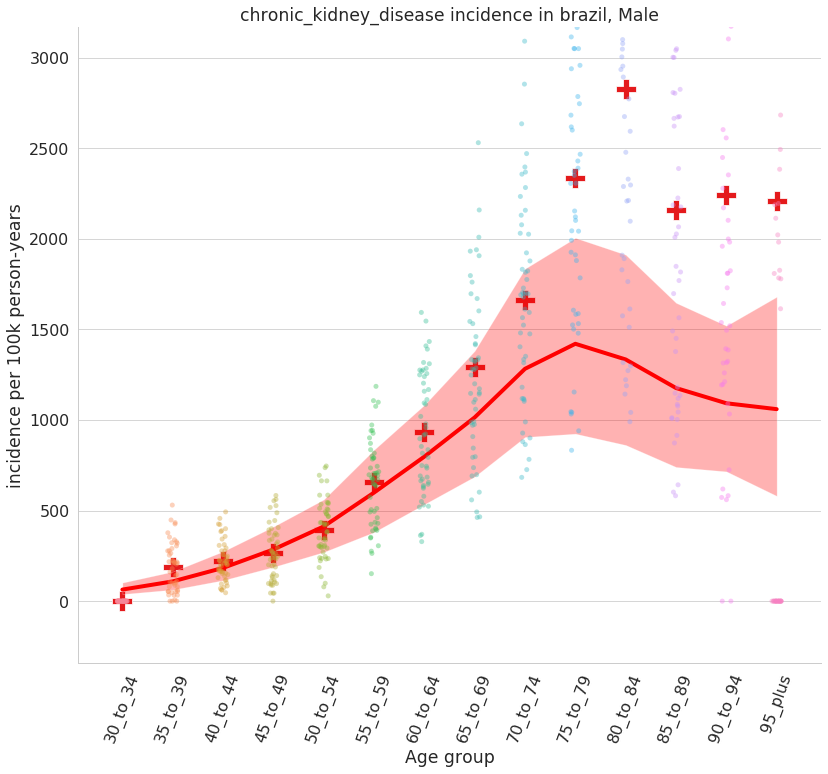

<Figure size 914.4x619.2 with 0 Axes>

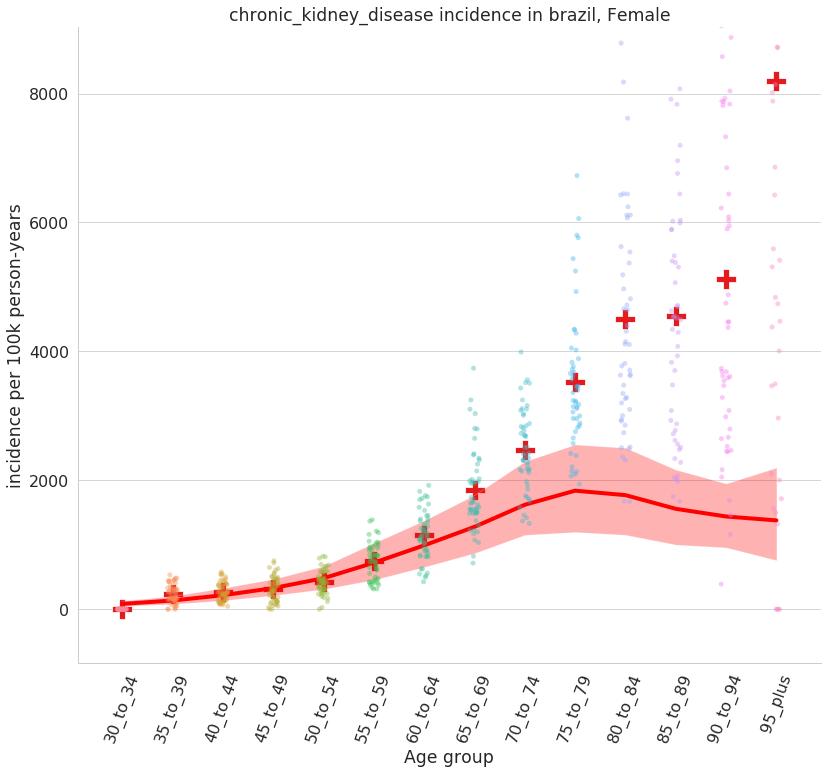

<Figure size 914.4x619.2 with 0 Axes>

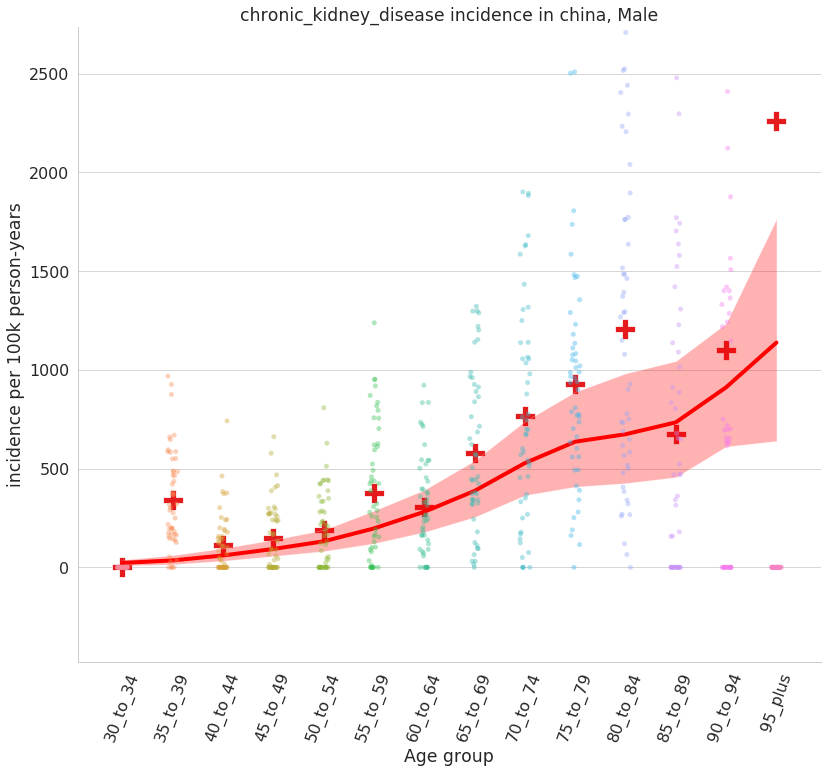

<Figure size 914.4x619.2 with 0 Axes>

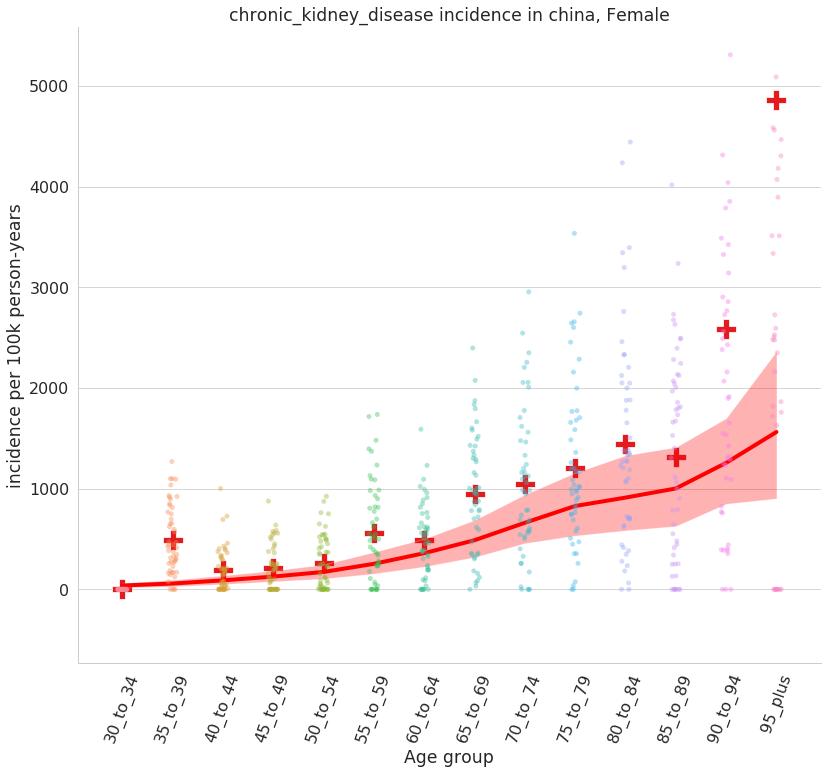

<Figure size 914.4x619.2 with 0 Axes>

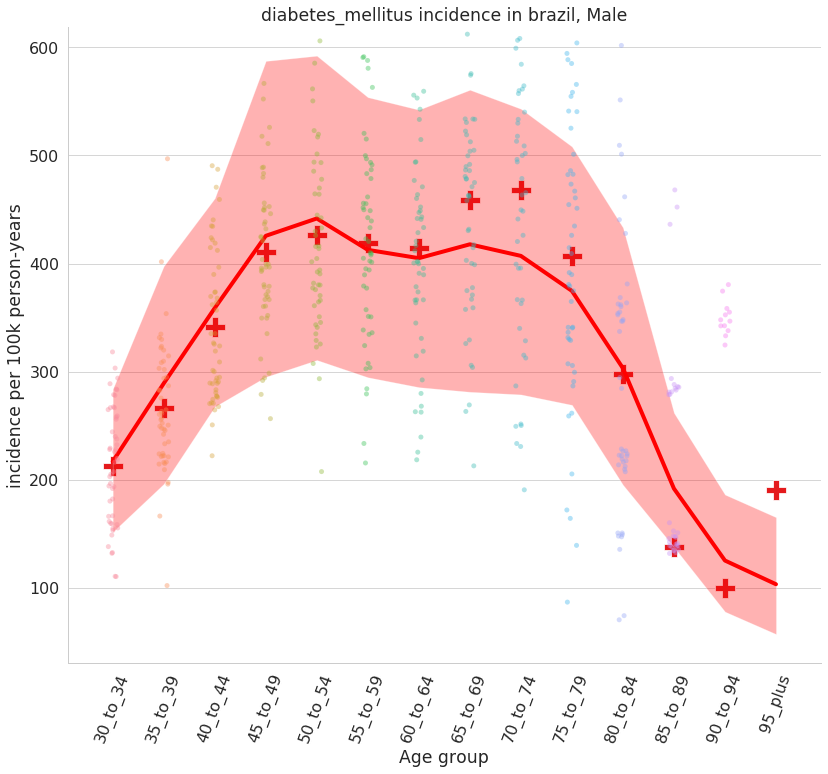

<Figure size 914.4x619.2 with 0 Axes>

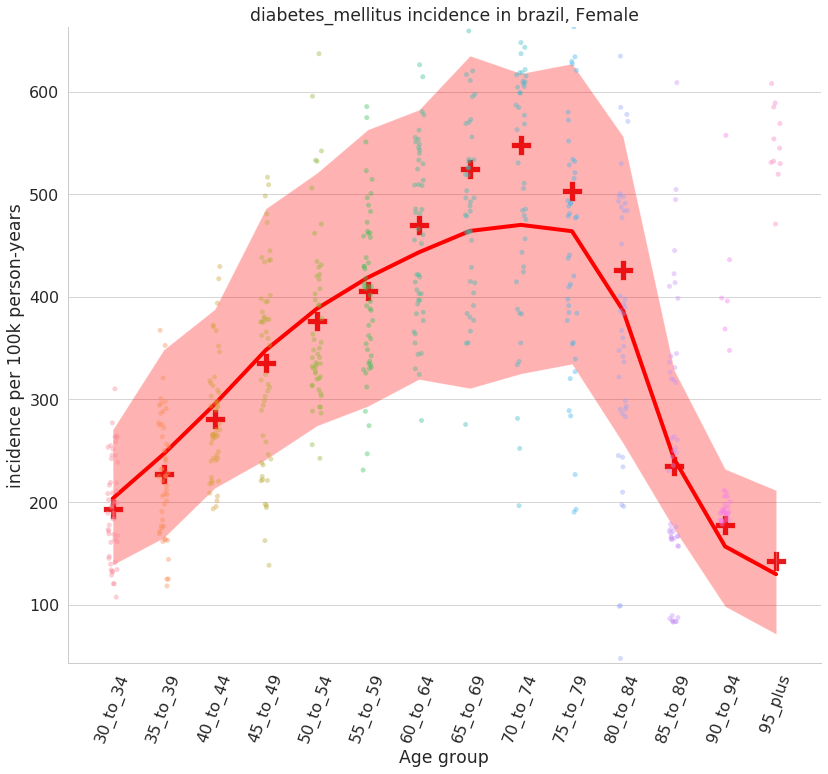

<Figure size 914.4x619.2 with 0 Axes>

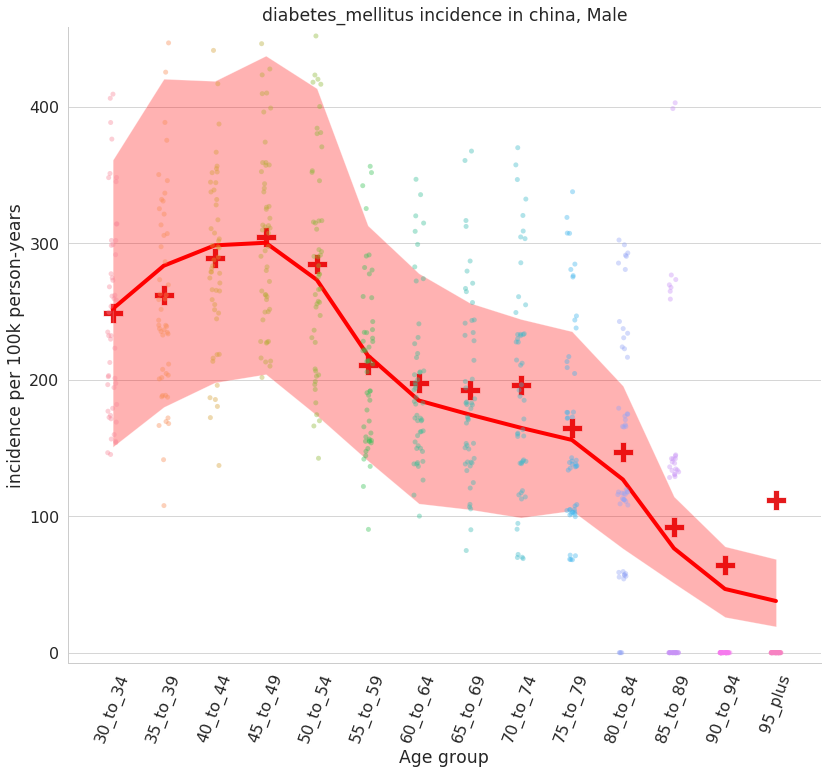

<Figure size 914.4x619.2 with 0 Axes>

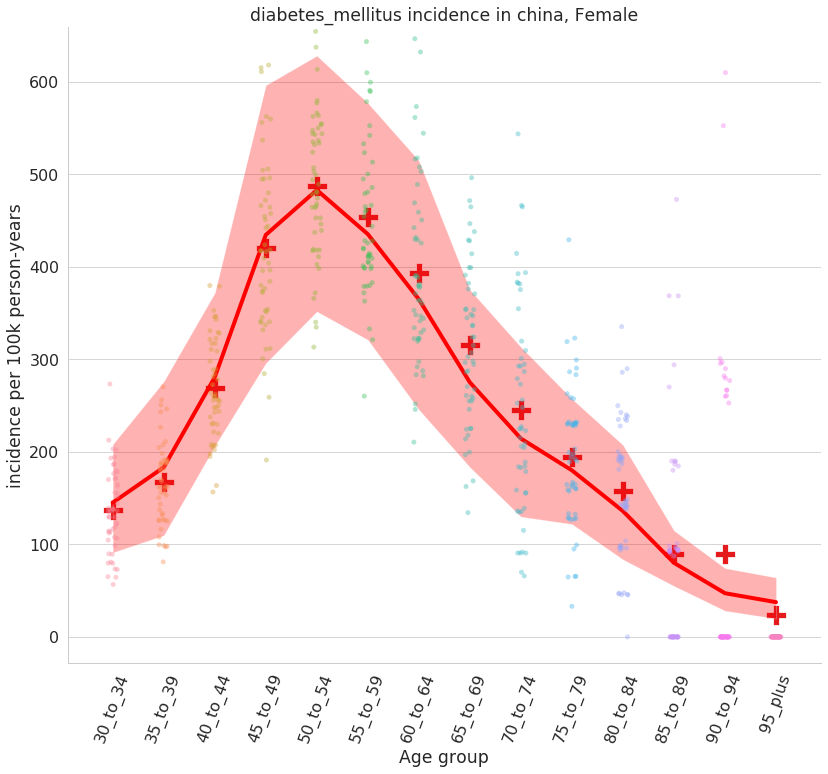

<Figure size 914.4x619.2 with 0 Axes>

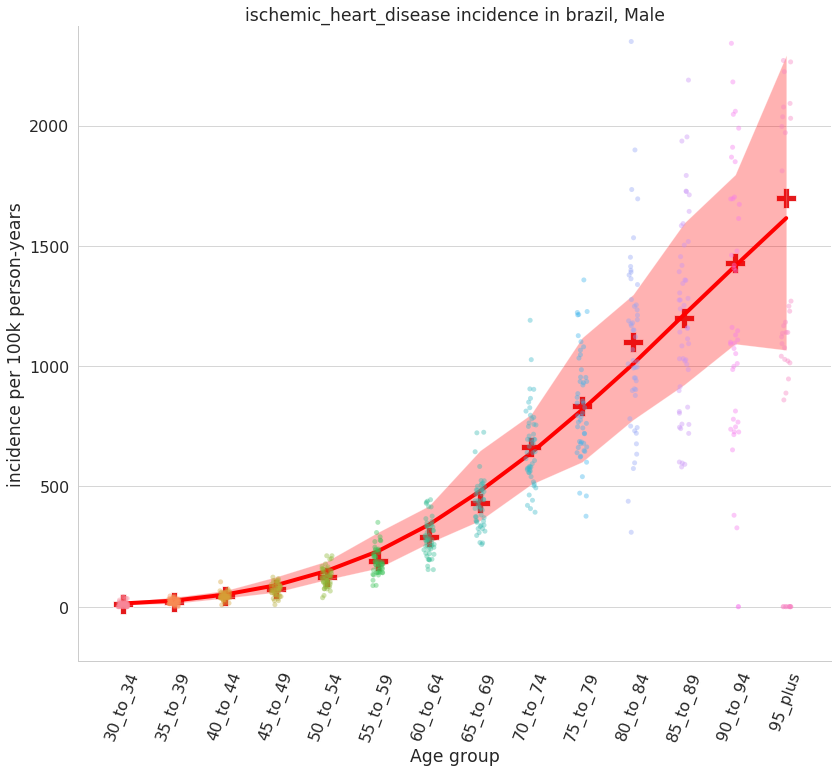

<Figure size 914.4x619.2 with 0 Axes>

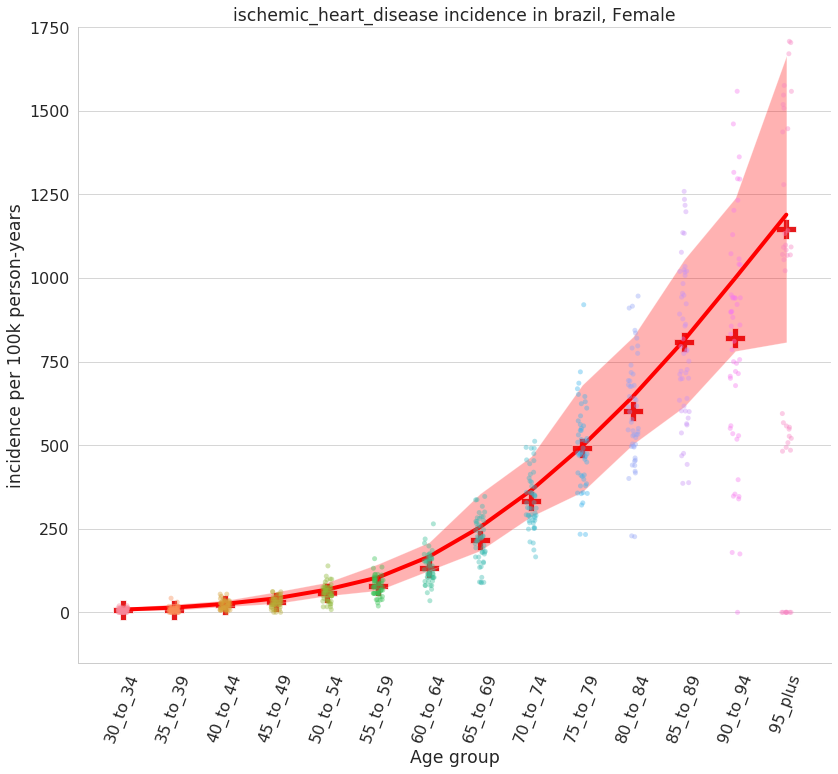

<Figure size 914.4x619.2 with 0 Axes>

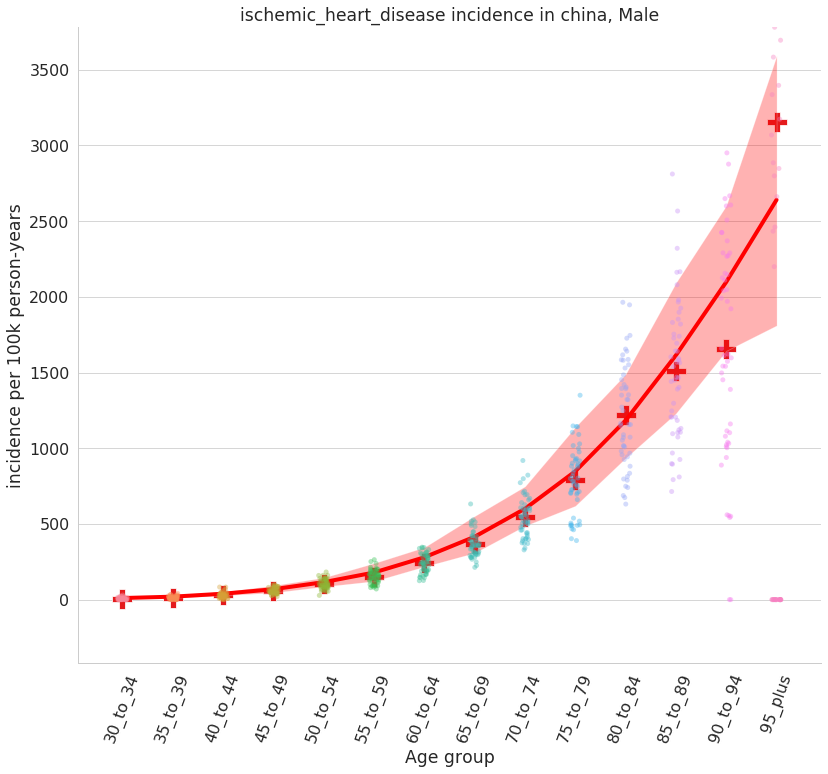

<Figure size 914.4x619.2 with 0 Axes>

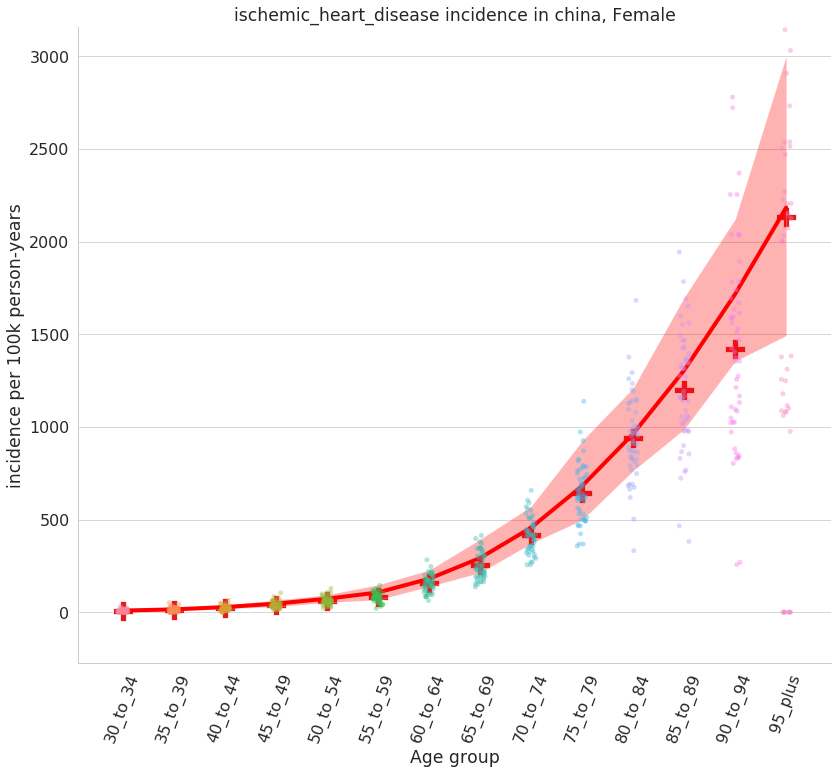

<Figure size 914.4x619.2 with 0 Axes>

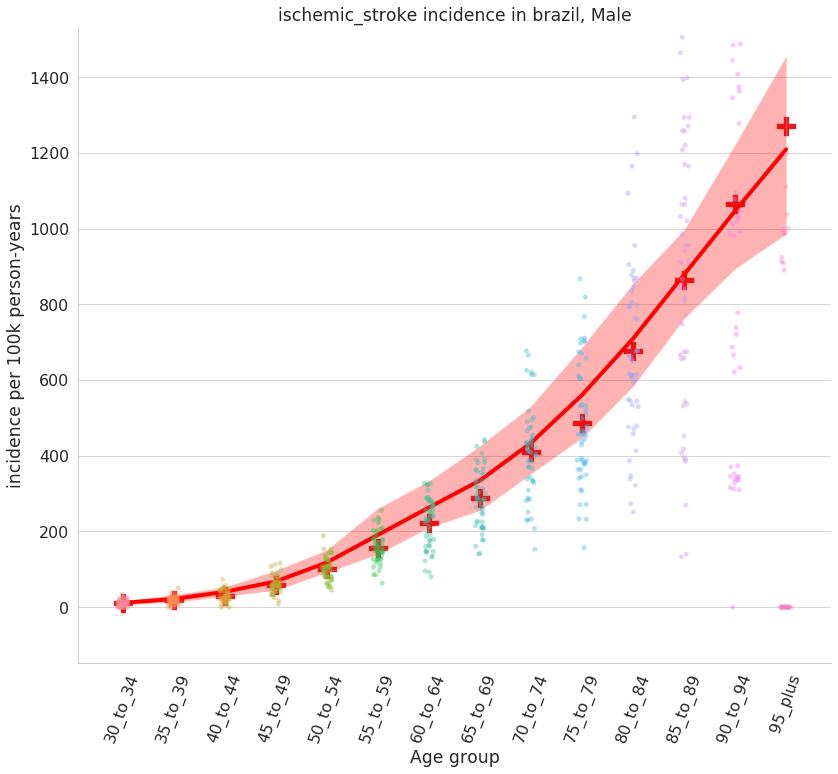

<Figure size 914.4x619.2 with 0 Axes>

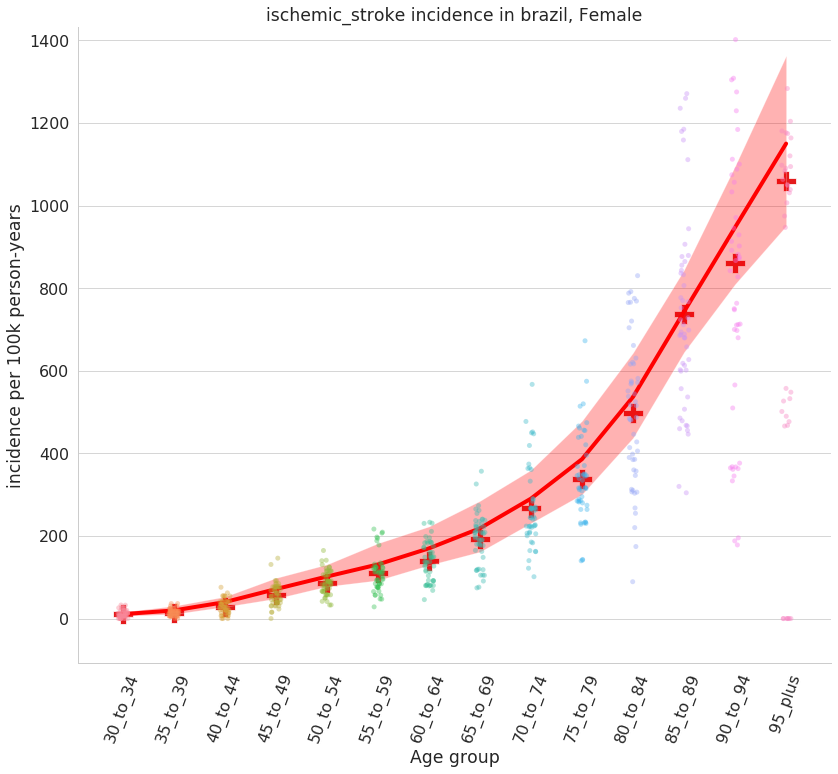

<Figure size 914.4x619.2 with 0 Axes>

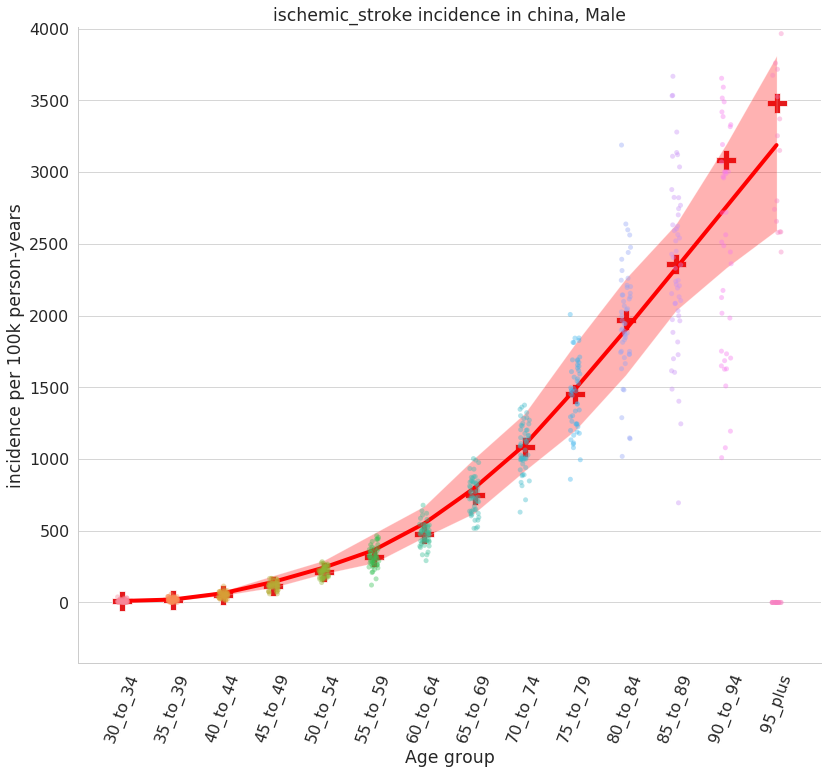

<Figure size 914.4x619.2 with 0 Axes>

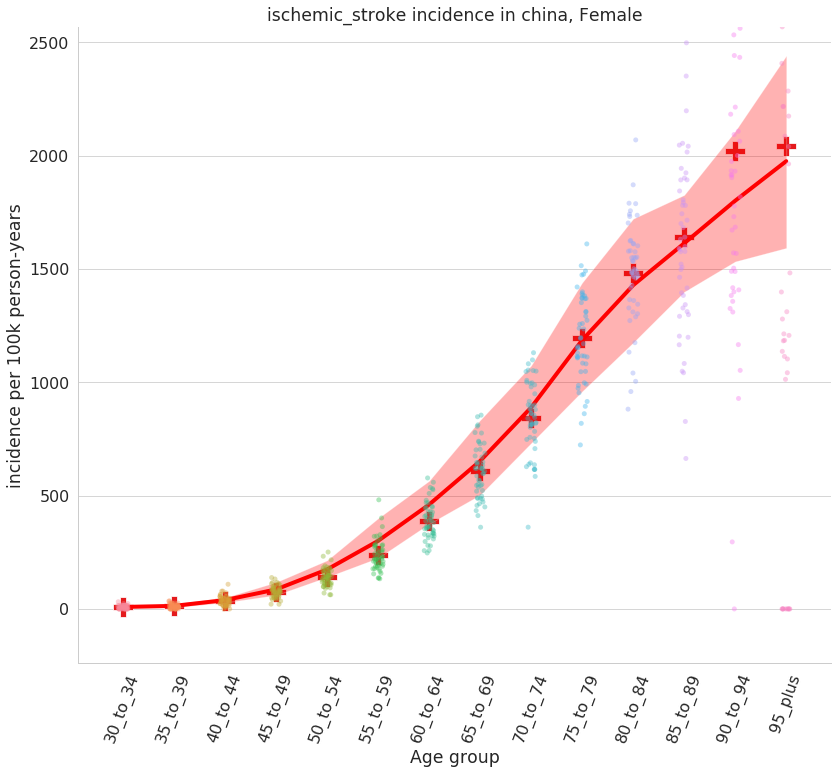

<Figure size 914.4x619.2 with 0 Axes>

In [9]:
def plot_results(rates,locations,gbd):
    cause_names = ['chronic_kidney_disease', 'diabetes_mellitus', 'ischemic_heart_disease', 'ischemic_stroke',]
    for cause in cause_names:
#         with PdfPages(str(save_path_j)+f'/model_6_outputs_gbd_compare/cause/{cause}_m6.pdf') as pdf:   
#         with PdfPages(f'{cause}_m5_new_incidence.pdf') as pdf:
#             for measure in ['deaths','ylls', 'ylds', 'prevalence', 'incidence']:
            for measure in ['incidence']:
                for location in locations:
                    with PdfPages(str(save_path_j)+f'/model_6_outputs_gbd_compare/{cause}_{measure}_{location}_new_incidence_m6.pdf') as pdf:
                        for sex in ['Male', 'Female']:

                            data_r = rates[(rates.cause == cause) & (rates.sex == sex) & (rates.measure == measure) & (rates.location == location) & (rates.year == '2020')]
                            data_m = data_r.groupby(['age_group']).value.mean().reset_index()
                            data_g = gbd[(gbd.cause == cause) & (gbd.sex == sex) & (gbd.measure == measure) & (gbd.location == location)]

                            g = sns.catplot(x='age_group', y='value',
                                            height=10, aspect=1.2, alpha=0.4,
                                            data=data_r)
                            sns.scatterplot(x='age_group', y='value', 
                                            s=400, marker='P',
                                            ax=g.ax, legend=False, data=data_m)
                            sns.lineplot(x='age_group', y='val',
                                         color='red', linewidth=4, legend=False, 
                                         ax=g.ax, data=data_g)

                            g.ax.fill_between(data_g.age_group, data_g.upper, data_g.lower, alpha=0.3, facecolor='red')

                            g.ax.set_title(f'{cause} {measure} in {location}, {sex}')
                            g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=70)
                            g.ax.set_xlabel('Age group')
                            g.ax.set_ylabel(f'{measure} per 100k person-years')

                            pdf.savefig(g.fig, orientation = 'landscape', bbox_inches='tight')

                            plt.show()
                            plt.clf() 

plot_results(rates,locations,gbd)